In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

from models import *
from series_restr import *
from utils import *


batch_size = 1
pred_len = 10
seq_len = 100
train_ratio = 0.9

### load data
df = pd.read_excel('data/df_eu.xlsx', sheet_name='df-eu')
Xcols = ['Cprice', 'Eprice', 'BrentOil', 'CrudeOilF', 'TTF-NatGas', 'NatGasF', 'Coal', 'GasolineF', 'DJI', 'S&P500', 'USD-EUR']
# note: Cprice at previous steps are also features for the current step
dataX = np.array(df[Xcols]) 
dataY = np.array(df['Cprice']).reshape(-1,1)
# print(dataX.shape)
# print(dataY.shape)

c:\Anaconda3\envs\torch37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.6642432966693453e-14
1.563246609334534e-14


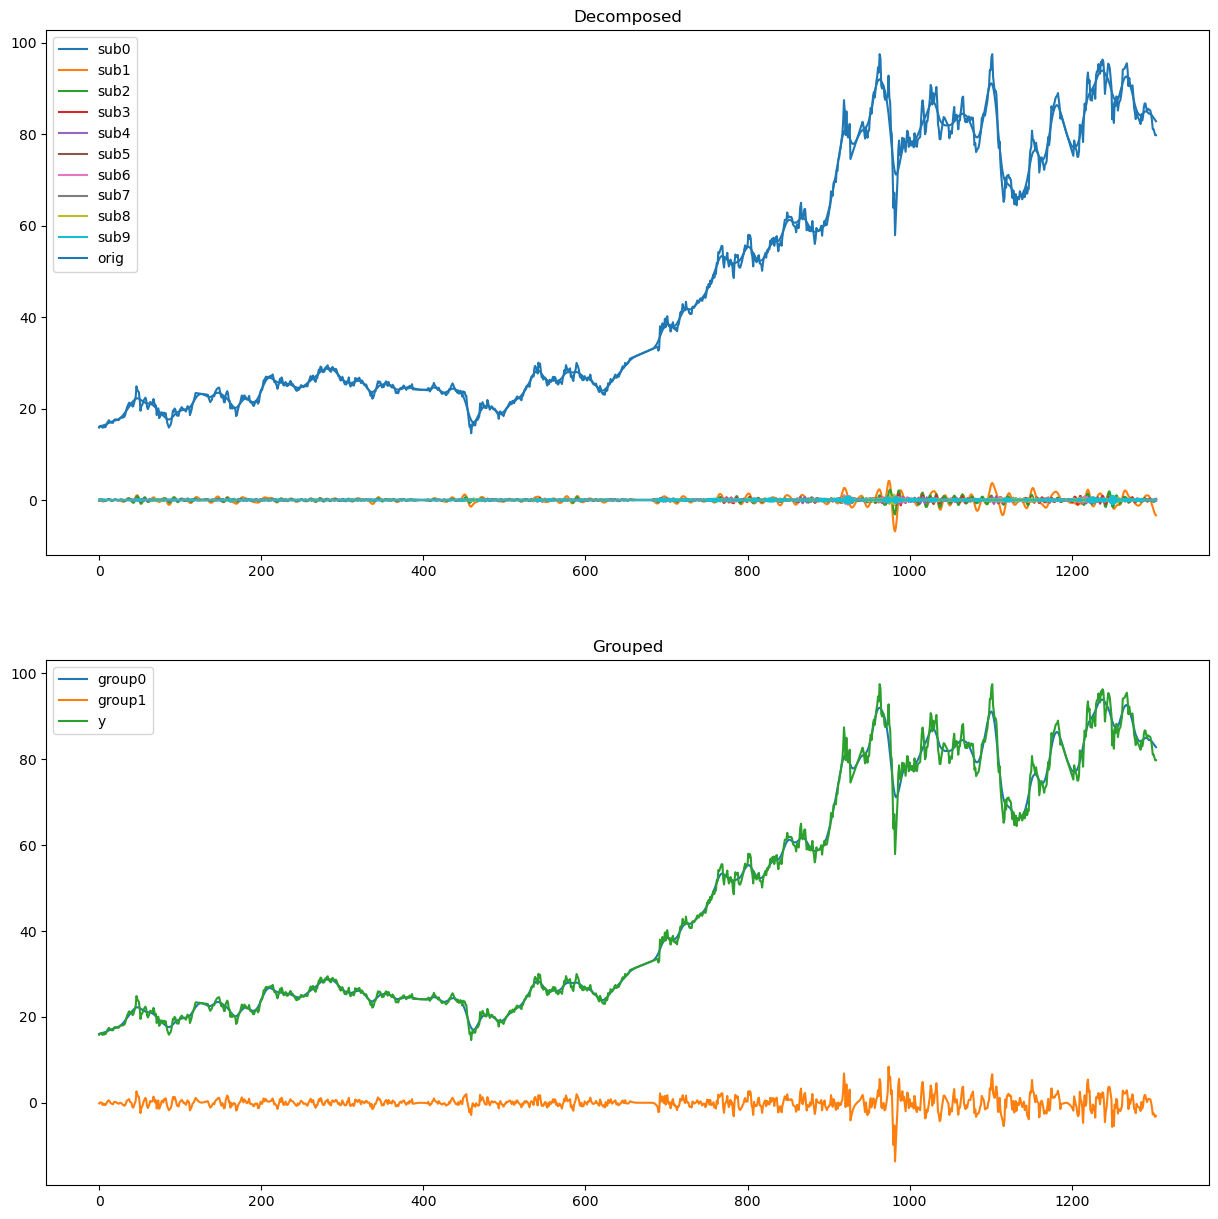

In [44]:
reconstr = restr_ssa(dataY.reshape(-1), n_decomp=10, n_integr=2, vis=True)

In [13]:
batch_size = 1
pred_len = 10
seq_len = 100

pred = np.zeros((reconstr.shape[1]-seq_len-pred_len+1, pred_len))
real = np.zeros((reconstr.shape[1]-seq_len-pred_len+1, pred_len))

batch_size = 1
for i in range(reconstr.shape[0]):
    print(i)
    subY = reconstr[i,:].reshape(-1,1)
    m = TCN_model('sg-nowin-TCN'+str(i), batch_size)
    m.prepare_data(dataX, subY, seq_len=100, pred_len=10)
    m.init_model()
    m.train_model(train_ratio=1, val_ratio=0.2)
    # m.load_model()
    sub_pred, sub_real = m.test_model(test_ratio=1)
    pred += sub_pred
    real += sub_real

0
epoch 001 train_loss 0.00540458 val_loss 0.00446478
epoch 002 train_loss 0.00481594 val_loss 0.00380728
epoch 003 train_loss 0.00546801 val_loss 0.00479815
EarlyStopping counter: 1 out of 7
epoch 004 train_loss 0.00482735 val_loss 0.00328973
epoch 005 train_loss 0.00559781 val_loss 0.00544284
EarlyStopping counter: 1 out of 7
epoch 006 train_loss 0.00478804 val_loss 0.00440359
EarlyStopping counter: 2 out of 7
epoch 007 train_loss 0.00482228 val_loss 0.00649850
EarlyStopping counter: 3 out of 7
epoch 008 train_loss 0.00490657 val_loss 0.00436338
EarlyStopping counter: 4 out of 7
epoch 009 train_loss 0.00461117 val_loss 0.00346360
EarlyStopping counter: 5 out of 7
epoch 010 train_loss 0.00409098 val_loss 0.00312293
epoch 011 train_loss 0.00478479 val_loss 0.00472304
EarlyStopping counter: 1 out of 7
epoch 012 train_loss 0.00492880 val_loss 0.00397971
EarlyStopping counter: 2 out of 7
epoch 013 train_loss 0.00411815 val_loss 0.00445657
EarlyStopping counter: 3 out of 7
epoch 014 train_

performance of hb-nowin-TCN
col 0: RMSE=2.39, MAPE=3.60%
col 1: RMSE=2.37, MAPE=3.57%
col 2: RMSE=2.37, MAPE=3.59%
col 3: RMSE=2.43, MAPE=3.73%
col 4: RMSE=2.42, MAPE=3.79%
col 5: RMSE=2.46, MAPE=3.91%
col 6: RMSE=2.45, MAPE=3.97%
col 7: RMSE=2.50, MAPE=4.09%
col 8: RMSE=2.60, MAPE=4.24%
col 9: RMSE=2.68, MAPE=4.35%


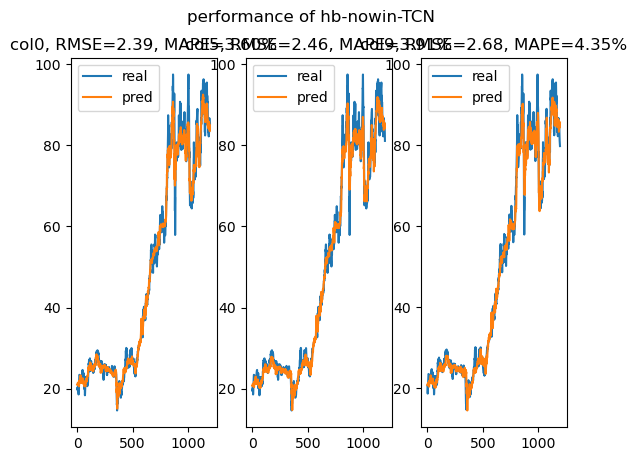

In [14]:
show_performance('hb-nowin-TCN', pred, real, vis=True)

In [13]:
import pmdarima as pm
from copy import deepcopy

trail_name = "sg_nowin_arima"
print(colored(trail_name, 'blue'))

split = int( (len(dataY)-seq_len-pred_len+1) * train_ratio ) + seq_len
trainY, testY = dataY[:split], dataY[split:]

# fit arima model with training set
model = pm.auto_arima(  
    trainY, start_p=1, start_q=1,
    max_p=10, max_q=10,         # maximum p and q
    information_criterion='aic',# 'aic', 'aicc', 'bic', 'hqic', 'oob'
    d=None,                     # let model determine 'd'
    test='adf',                 # use adftest to find optimal 'd', or 'kpss', 'pp'
    m=1,                        # frequency of series, m=1 means non-seasonal
    seasonal=False,             # no Seasonality
    trace=False,                # don't print status on the fits
    error_action='ignore',      # don't want to know if an order does not work
    suppress_warnings=True,     # don't want convergence warnings
    stepwise=True               # The stepwise algorithm can be significantly faster than
                                # a non-stepwise selection (i.e., essentially a grid search) 
                                # and is less likely to over-fit the model. 
) 
print(model.summary())


sg_nowin_arima
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1176
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -1961.257
Date:                Fri, 10 Nov 2023   AIC                           3936.513
Time:                        13:14:46   BIC                           3971.996
Sample:                             0   HQIC                          3949.893
                               - 1176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.002      2.061      0.039       0.000       0.008
ar.L1          0.9893      0.023     43.438      0.000       0.945       1.034
ar.L2          0.0253      0.019     

In [18]:
# predict with test set
pred = []
real = []
for i in range(len(testY)-pred_len+1):
    model_copy = deepcopy(model)
    if i != 0:
        model_copy.update(testY[:i])
    new_pred = model_copy.predict(n_periods=pred_len, return_conf_int=False)
    pred.append(new_pred)
    real.append(dataY[split+i: split+i+pred_len])

pred = np.array(pred)
real = np.array(real)
print(pred.shape)
print(real.shape)
show_performance('sg-nowin-arima', pred, real, vis=True)

KeyboardInterrupt: 

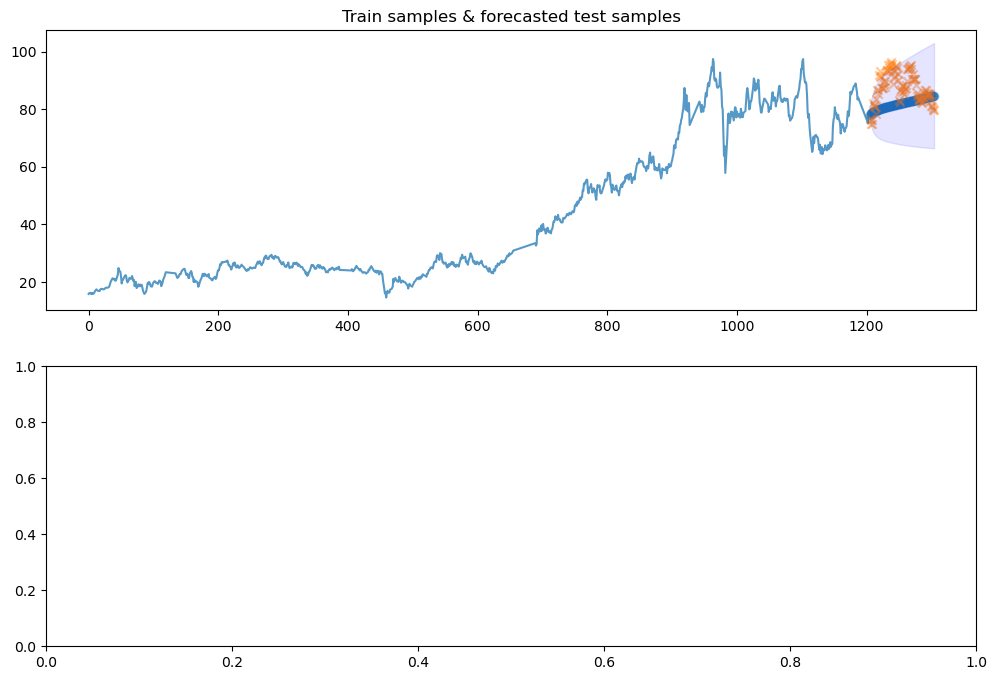

In [42]:
# Now plot the results and the forecast for the test set
preds, conf_int = model.predict(n_periods=testY.shape[0],
                                return_conf_int=True)

plotTrain = 100

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(trainY.shape[0] + preds.shape[0])
axes[0].set_title("Train samples & forecasted test samples")
axes[0].plot(x_axis[:trainY.shape[0]], trainY, alpha=0.75)
axes[0].scatter(x_axis[trainY.shape[0]:], preds, alpha=0.4, marker='o')
axes[0].scatter(x_axis[trainY.shape[0]:], testY, alpha=0.4, marker='x')
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')



# Now add the actual samples to the model and create NEW forecasts
model.update(testY)
new_preds, new_conf_int = model.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(data.shape[0] + 10)

axes[1].plot(new_x_axis[:data.shape[0]], data, alpha=0.75)
axes[1].scatter(new_x_axis[data.shape[0]:], new_preds, alpha=0.4, marker='o')
axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
                     new_conf_int[:, 0],
                     new_conf_int[:, 1],
                     alpha=0.1, color='g')
axes[1].set_title("Added new observed values with new forecasts")
plt.show()

In [71]:
pred_len = 10
seq_len = 100

cols_prev = pd.DataFrame(dict([ ('Cprice'+str(i), df['Cprice'].shift(i)) for i in range(1, seq_len+1) ]))
cols_future = pd.DataFrame(dict([ ('Cprice'+str(-i), df['Cprice'].shift(-i)) for i in range(1, pred_len) ]))
df0 = pd.concat([df]+[cols_prev]+[cols_future], axis=1).dropna()
dataY0 = df0[['Cprice']+list(cols_future.columns)]
dataX0 = df0.drop(['Unnamed: 0', 'Date']+list(dataY0.columns), axis=1)

print(dataX0.shape, dataY0.shape)


from sklearn.decomposition import PCA
pca = PCA(n_components=0.9999) # 95% variance / 10 / 'mle'
pca.fit(dataX0)
dataX0_pca = pca.transform(dataX0)
print(dataX0_pca.shape)
# pca.explained_variance_ratio_



# dataY = np.array(df['Cprice']).reshape(-1,1)
# dataX = np.array(df[Xcols].drop(columns=['Cprice']))
# print(dataX.shape, dataY.shape)


# dataYroll = df['Cprice'].rolling(12).mean().dropna()
# dataXroll = df[Xcols].rolling(12).mean().dropna()
# dataYroll = np.array(dataYroll).reshape(-1,1)
# dataXroll = np.array(dataXroll)
# print(dataXroll.shape, dataYroll.shape)

(1196, 110) (1196, 10)
(1196, 6)


In [220]:
reconstrY = np.array( series_restr_func(dataY, decomp_method='ssa', n_integr=2)[0] ).reshape(-1,1)
reconstrX = np.array([ series_restr_func(dataX[:,i], decomp_method='ssa', n_integr=2)[0] for i in range(dataX.shape[1]) ]).T
print(reconstrX.shape, reconstrY.shape)

# x = df[Xcols]
# y = reconstr[0,:].reshape(-1,1)

(1305, 11) (1305, 1)


R2: -0.06370048346060564
RMSE: 5.802456092842175
MAPE: 5.385880930773397


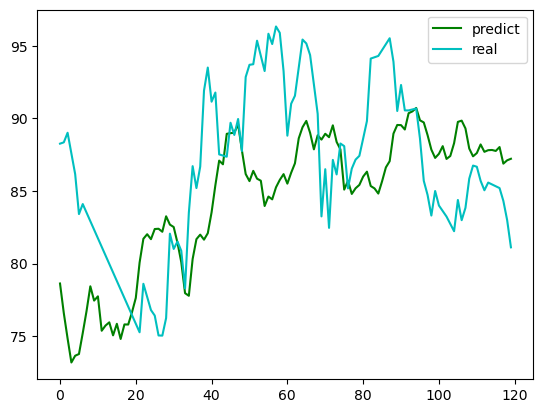

In [76]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

np.random.seed(0)


def pred_svr(x, y):
    x, y = np.array(x), np.array(y)
    scalarX, scalarY = StandardScaler(), StandardScaler()
    x = scalarX.fit_transform(x)
    y = scalarY.fit_transform(y.reshape(-1,1)).reshape(-1)
    
    split = -120
    x_tran, x_test = x[:split], x[split:]
    y_tran, y_test = y[:split], y[split:]
    
    clf = SVR(
        kernel ='rbf',  # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
        gamma = 0.001,  # kernel coefficient for 'rbf', 'poly' and 'sigmoid', auto = 1 / n_features
        coef0 = 0.0,    # independent term in kernel function, important in 'poly' and 'sigmoid'
        tol = 0.001,    # tolerance for stopping criterion
        C = 10.0,        # penalty parameter C of the error term
        epsilon = 0.01,  # epsilon in the epsilon-SVR model
        # degree = 3,     # degree of polynomial, ignored with other kernels
        # shrinking = True,   # whether to use the shrinking heuristic
        # cache_size = 200,   # kernel cache size in MB
        # verbose = False,    # enable verbose output
        # max_iter = -1,      # limit on iterations within solver, -1 for no limit
    )
    clf.fit(x_tran, y_tran)

    y_pred = clf.predict(x_test)
    y_pred = scalarY.inverse_transform(y_pred.reshape(-1,1))
    y_real = scalarY.inverse_transform(y_test.reshape(-1,1))

    print("R2:", r2_score(y_real, y_pred))
    print("RMSE:", mean_squared_error(y_real, y_pred)**0.5)
    print("MAPE:", mean_absolute_percentage_error(y_real, y_pred)*100)

    plt.plot(y_pred, 'g-', label="predict")
    plt.plot(y_real, 'c-', label="real")
    plt.legend()
    plt.show()
    
    return y_pred, y_real

_,_ = pred_svr(dataX0, dataY0['Cprice-5'])
# _,_ = pred_svr(reconstrX, reconstrY)

In [41]:
df['Cprice'].rolling(12).mean()

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
1300    85.001667
1301    84.606667
1302    84.081667
1303    83.508333
1304    83.015833
Name: Cprice, Length: 1305, dtype: float64

In [42]:
df['Cprice']

0       15.850
1       16.150
2       16.185
3       16.220
4       15.800
         ...  
1300    81.120
1301    81.110
1302    80.450
1303    79.790
1304    79.790
Name: Cprice, Length: 1305, dtype: float64

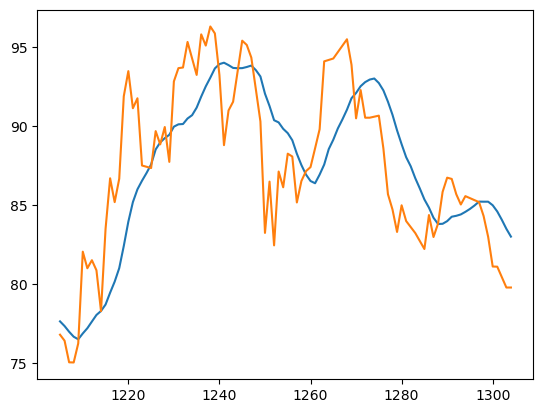

In [39]:
plt.plot(df['Cprice'].rolling(12).mean()[-100:])
plt.plot(df['Cprice'][-100:])